In [1]:
#import sys
#sys.path.append('/Users/huangxingyue/Desktop/NYU MFE/12 Capstone')
import numpy as np
import pandas as pd
import math
from Pricing.MC_simulation import *
from Fitter.fitter import Fitter
from Pricing.BS import *
from matplotlib import pyplot as plt

** Take data of 5Y tenor and 10Y expiry as an example **

In [3]:
fitter=Fitter('market_data.xlsx')
results=fitter.calibration() #Hagan lognormal implementation
ivols=fitter.ivol_SABR(results['alpha'],results['beta'],results['rho'],results['nu'])
params=results['params']

factors=params.loc[13,:][2:]
vols=ivols.loc[13,:]
print ('params:\n', factors)
print ('ivols:\n', vols)

('params:\n', F        0.033460
alpha    0.038784
beta     0.496106
rho     -0.234414
nu       0.340765
Name: 13, dtype: float64)
('ivols:\n', tenor      5.000000
expiry    10.000000
F          0.033460
-150       0.310796
-100       0.274907
-50        0.248788
-25        0.238716
0          0.230399
25         0.223683
50         0.218408
100        0.211501
150        0.208300
Name: 13, dtype: float64)


### MC Euler scheme

#### case1: $\nu=0$ for $\rho=\{0,0.8,-0.8\}$ and $\beta=\{0,0.3,0.5,0.7,1\}$ with $n_{sim}=100000, n_{step}=40$

In [3]:
results=[]
for rho in [0,0.8,-0.8]:
    for beta in [0,0.3,0.5,0.7,1]:
        res=minimize(objfunc_atm,0,(beta,rho,0,vols['F'],10,vols[0]))
        result=[res.x[0],beta,rho,0]
        forwards1=simulateSABRMonteCarloEuler(100000,40,10,vols['F'],res.x[0],beta,rho,0)
        #forwards2=simulateSABRMonteCarloMilstein(100000,40, 10, vols['F'],0.0071957323083426811,0,0,0.25)
        MC_price=[]
        for K_spread in vols.index.tolist()[3:]:
            option=[max(0, item-(vols['F']+K_spread/10000.)) for item in forwards1]
            MC_price.append(sum(option)/len(option))
        for counter, K_spread in enumerate(vols.index.tolist()[3:]):
            result.append(find_ivol(MC_price[counter],vols['F'],vols['F']+K_spread/10000.,10))
        result.append(np.std(forwards1))
        results.append(result)
results=pd.DataFrame(results,columns=['alpha','beta','rho','nu','-150','-100','-50','-25','0','25','50','100','150','MC standard error'])
print (results)

       alpha  beta  rho  nu    -150    -100     -50     -25       0      25  \
0   0.007549   0.0  0.0   0  0.3157  0.2796  0.2530  0.2420  0.2323  0.2235   
1   0.021138   0.3  0.0   0  0.2863  0.2631  0.2453  0.2378  0.2311  0.2249   
2   0.041916   0.5  0.0   0  0.2729  0.2558  0.2428  0.2373  0.2324  0.2280   
3   0.082981   0.7  0.0   0  0.2548  0.2449  0.2373  0.2341  0.2312  0.2285   
4   0.230399   1.0  0.0   0  0.2358  0.2340  0.2330  0.2326  0.2323  0.2320   
5   0.007549   0.0  0.8   0  0.3114  0.2769  0.2512  0.2406  0.2311  0.2225   
6   0.021138   0.3  0.8   0  0.2830  0.2612  0.2442  0.2370  0.2305  0.2246   
7   0.041916   0.5  0.8   0  0.2643  0.2503  0.2391  0.2343  0.2299  0.2258   
8   0.082981   0.7  0.8   0  0.2494  0.2412  0.2345  0.2315  0.2287  0.2261   
9   0.230399   1.0  0.8   0  0.2312  0.2314  0.2313  0.2313  0.2312  0.2310   
10  0.007549   0.0 -0.8   0  0.3119  0.2767  0.2508  0.2402  0.2307  0.2221   
11  0.021138   0.3 -0.8   0  0.2804  0.2589  0.2422 

#### case2: $\rho=0$ for $\nu=\{0.25,0.5\}$ and $\beta=\{0,0.3,0.5,0.7,1\}$ with $n_{sim}=100000, n_{step}=40$

In [4]:
results=[]
for nu in [0.25,0.5]:
    for beta in [0,0.3,0.5,0.7,1]:
        res=minimize(objfunc_atm,0,(beta,0,nu,vols['F'],10,vols[0]))
        result=[res.x[0],beta,0,nu]
        forwards1=simulateSABRMonteCarloEuler(100000,40,10,vols['F'],res.x[0],beta,0,nu)
        MC_price=[]
        for K_spread in vols.index.tolist()[3:]:
            option=[max(0, item-(vols['F']+K_spread/10000.)) for item in forwards1]
            MC_price.append(sum(option)/len(option))
        for counter, K_spread in enumerate(vols.index.tolist()[3:]):
            result.append(find_ivol(MC_price[counter],vols['F'],vols['F']+K_spread/10000.,10))
        result.append(np.std(forwards1))
        results.append(result)
results=pd.DataFrame(results,columns=['alpha','beta','rho','nu','-150','-100','-50','-25','0','25','50','100','150','MC standard error'])
print (results)

      alpha  beta  rho    nu    -150    -100     -50     -25       0      25  \
0  0.007196   0.0    0  0.25  0.3271  0.2842  0.2539  0.2422  0.2322  0.2237   
1  0.020121   0.3    0  0.25  0.2817  0.2557  0.2370  0.2297  0.2235  0.2183   
2  0.039871   0.5    0  0.25  0.2763  0.2535  0.2378  0.2319  0.2270  0.2230   
3  0.078895   0.7    0  0.25  0.2559  0.2410  0.2309  0.2273  0.2244  0.2222   
4  0.218993   1.0    0  0.25  0.2403  0.2318  0.2273  0.2262  0.2257  0.2256   
5  0.006303   0.0    0  0.50  0.3478  0.2900  0.2513  0.2376  0.2272  0.2197   
6  0.017573   0.3    0  0.50  0.2846  0.2473  0.2218  0.2130  0.2068  0.2027   
7  0.034770   0.5    0  0.50  0.2687  0.2368  0.2155  0.2085  0.2038  0.2012   
8  0.068733   0.7    0  0.50  0.2707  0.2398  0.2200  0.2139  0.2102  0.2085   
9  0.190675   1.0    0  0.50     NaN     NaN     NaN     NaN     NaN     NaN   

       50     100     150  MC standard error  
0  0.2165  0.2053  0.1973       2.692878e-02  
1  0.2139  0.2072  0.2026

#### case3: $\rho=\{0.8,-0.8\}$ for $\nu=\{0.25,0.5\}$ and $\beta=\{0,0.3,0.5,0.7,1\}$ with $n_{sim}=100000, n_{step}=40$

In [5]:
results=[]
for rho in [0.8,-0.8]:    
    for nu in [0.25,0.5]:
        for beta in [0,0.3,0.5,0.7,1]:
            res=minimize(objfunc_atm,0,(beta,rho,nu,vols['F'],10,vols[0]))
            result=[res.x[0],beta,rho,nu]
            forwards1=simulateSABRMonteCarloEuler(100000,40,10,vols['F'],res.x[0],beta,rho,nu)
            MC_price=[]
            for K_spread in vols.index.tolist()[3:]:
                option=[max(0, item-(vols['F']+K_spread/10000.)) for item in forwards1]
                MC_price.append(sum(option)/len(option))
            for counter, K_spread in enumerate(vols.index.tolist()[3:]):
                result.append(find_ivol(MC_price[counter],vols['F'],vols['F']+K_spread/10000.,10))
            result.append(np.std(forwards1))
            results.append(result)
results=pd.DataFrame(results,columns=['alpha','beta','rho','nu','-150','-100','-50','-25','0','25','50','100','150','MC standard error'])
print (results)

       alpha  beta  rho    nu    -150    -100     -50     -25       0      25  \
0   0.007534   0.0  0.8  0.25  0.2496  0.2390  0.2329  0.2310  0.2294  0.2282   
1   0.020441   0.3  0.8  0.25  0.2399  0.2356  0.2351  0.2355  0.2360  0.2367   
2   0.039712   0.5  0.8  0.25  0.2220  0.2252  0.2305  0.2333  0.2361  0.2387   
3   0.077090   0.7  0.8  0.25  0.2069  0.2166  0.2272  0.2322  0.2369  0.2413   
4   0.208276   1.0  0.8  0.25  0.3133  0.2992  0.3033  0.3078  0.3129  0.3184   
5   0.007490   0.0  0.8  0.50  0.2418  0.2280  0.2294  0.2327  0.2366  0.2406   
6   0.019752   0.3  0.8  0.50  0.2288  0.2203  0.2279  0.2342  0.2409  0.2475   
7   0.037764   0.5  0.8  0.50  0.2260  0.2178  0.2280  0.2360  0.2444  0.2527   
8   0.072296   0.7  0.8  0.50  0.2866  0.2645  0.2706  0.2786  0.2875  0.2966   
9   0.191954   1.0  0.8  0.50     NaN     NaN     NaN     NaN     NaN     NaN   
10  0.007534   0.0 -0.8  0.25  0.3791  0.3164  0.2694  0.2500  0.2325  0.2167   
11  0.021841   0.3 -0.8  0.2

#### case4: MC with SABR parameters calibrated, $n_{sim}=100000, n_{step}=40$

('MC standard error:', 0.026588982072259758)


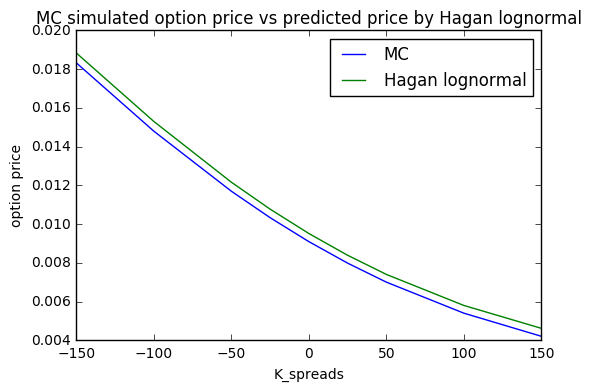

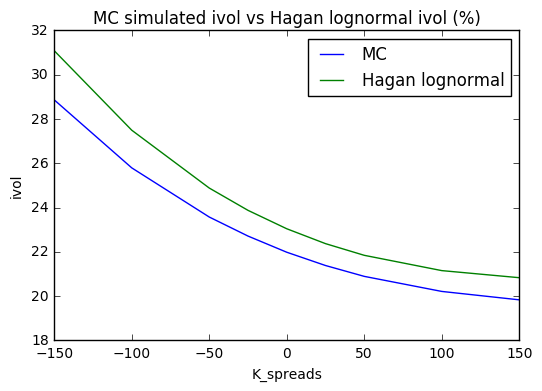

In [6]:
forwards1=simulateSABRMonteCarloEuler(100000,40,10,vols['F'],factors['alpha'],factors['beta'],factors['rho'],factors['nu'])
print ('MC standard error:', np.std(forwards1))

#plot MC simulated option prices against BS prices with Hagan ivol
p1=[] #MC simulated option price
p2=[] #BS price by Hagan ivol
for K_spread in vols.index.tolist()[3:]:
    option=[max(0, item-(vols['F']+K_spread/10000.)) for item in forwards1]
    p1.append(sum(option)/len(option))
    p2.append(black(vols['F'],(vols['F']+K_spread/10000.),10,vols[K_spread],1))  
plt.plot(vols.index.tolist()[3:],p1,label='MC')
plt.plot(vols.index.tolist()[3:],p2,label='Hagan lognormal')
plt.title('MC simulated option price vs predicted price by Hagan lognormal')
plt.xlabel('K_spreads')
plt.ylabel('option price')
plt.legend()
plt.show()

#plot MC simulated ivols against Hagan ivols
ivols_hagan=vols.values[3:] #Hagan ivol
ivols_MC=[] #MC simulated ivol
for counter, K_spread in enumerate(vols.index.tolist()[3:]):
    ivols_MC.append(find_ivol(p1[counter],vols['F'],vols['F']+K_spread/10000.,10))
plt.plot(vols.index.tolist()[3:],[item*100 for item in ivols_MC],label='MC')
plt.plot(vols.index.tolist()[3:],[item*100 for item in ivols_hagan],label='Hagan lognormal')
plt.title('MC simulated ivol vs Hagan lognormal ivol (%)')
plt.xlabel('K_spreads')
plt.ylabel('ivol')
plt.legend()
plt.show()

### MC Milstein scheme

#### case5: $\rho=0,\nu=0.25$ for $\beta=\{0,0.3,0.5,0.7,1\}$ with $n_{sim}=100000, n_{step}=40$

In [7]:
results=[]
for beta in [0,0.3,0.5,0.7,1]:
    res=minimize(objfunc_atm,0,(beta,0,0.25,vols['F'],10,vols[0]))
    result=[res.x[0],beta,rho,nu]
    forwards2=simulateSABRMonteCarloMilstein(100000,40,10,vols['F'],res.x[0],beta,0,0.25)
    MC_price=[]
    for K_spread in vols.index.tolist()[3:]:
        option=[max(0, item-(vols['F']+K_spread/10000.)) for item in forwards2]
        MC_price.append(sum(option)/len(option))
    for counter, K_spread in enumerate(vols.index.tolist()[3:]):
        result.append(find_ivol(MC_price[counter],vols['F'],vols['F']+K_spread/10000.,10))
    result.append(np.std(forwards2))
    results.append(result)
results=pd.DataFrame(results,columns=['alpha','beta','rho','nu','-150','-100','-50','-25','0','25','50','100','150','MC standard error'])
print (results)

      alpha  beta  rho   nu    -150    -100     -50     -25       0      25  \
0  0.007196   0.0 -0.8  0.5  0.3235  0.2810  0.2512  0.2396  0.2298  0.2214   
1  0.020121   0.3 -0.8  0.5  0.2866  0.2594  0.2401  0.2326  0.2263  0.2209   
2  0.039871   0.5 -0.8  0.5  0.2751  0.2528  0.2376  0.2319  0.2271  0.2232   
3  0.078895   0.7 -0.8  0.5  0.2593  0.2435  0.2331  0.2295  0.2266  0.2244   
4  0.218993   1.0 -0.8  0.5  0.2412  0.2320  0.2277  0.2268  0.2266  0.2268   

       50     100     150  MC standard error  
0  0.2143  0.2031  0.1953           0.026569  
1  0.2164  0.2096  0.2049           0.025442  
2  0.2201  0.2154  0.2125           0.026760  
3  0.2228  0.2210  0.2205           0.030677  
4  0.2273  0.2292  0.2319           0.050466  


### General cases in validation parts

$\rho=\{0,0.8,-0.8\}$, $\nu=\{0.25,0.5\}$,$\beta=\{0,0.3,0.5,0.7,1\}$ with $n_{sim}=100000, n_{step}=40$

In [4]:
results=[]
for rho in [0,0.8,-0.8]:
    for beta in [0,0.3,0.5,0.7,1]:
        for nu in [0.25, 0.5]:
            res=minimize(objfunc_atm,0,(beta,rho,nu,vols['F'],10,vols[0]))
            result=[res.x[0],beta,rho,nu]
            forwards1=simulateSABRMonteCarloEuler(100000,40,10,vols['F'],res.x[0],beta,rho,nu)
            #forwards2=simulateSABRMonteCarloMilstein(100000,40, 10, vols['F'],0.0071957323083426811,0,0,0.25)
            MC_price=[]
            for K_spread in vols.index.tolist()[3:]:
                option=[max(0, item-(vols['F']+K_spread/10000.)) for item in forwards1]
                MC_price.append(sum(option)/len(option))
            for counter, K_spread in enumerate(vols.index.tolist()[3:]):
                result.append(find_ivol(MC_price[counter],vols['F'],vols['F']+K_spread/10000.,10))
            result.append(np.std(forwards1))
            results.append(result)
results=pd.DataFrame(results,columns=['alpha','beta','rho','nu','-150','-100','-50','-25','0','25','50','100','150','MC standard error'])
print (results)

       alpha  beta  rho    nu    -150    -100     -50     -25       0      25  \
0   0.007196   0.0  0.0  0.25  0.3254  0.2829  0.2531  0.2414  0.2315  0.2232   
1   0.006303   0.0  0.0  0.50  0.3575  0.2977  0.2574  0.2431  0.2324  0.2246   
2   0.020121   0.3  0.0  0.25  0.2843  0.2579  0.2391  0.2318  0.2256  0.2204   
3   0.017573   0.3  0.0  0.50  0.2807  0.2442  0.2194  0.2108  0.2046  0.2006   
4   0.039871   0.5  0.0  0.25  0.2767  0.2545  0.2391  0.2333  0.2284  0.2244   
5   0.034770   0.5  0.0  0.50  0.2812  0.2461  0.2228  0.2151  0.2099  0.2069   
6   0.078895   0.7  0.0  0.25  0.2651  0.2474  0.2359  0.2319  0.2288  0.2264   
7   0.068733   0.7  0.0  0.50  0.2726  0.2411  0.2209  0.2146  0.2107  0.2090   
8   0.218993   1.0  0.0  0.25  0.2470  0.2370  0.2318  0.2305  0.2298  0.2297   
9   0.190675   1.0  0.0  0.50     NaN     NaN     NaN     NaN     NaN     NaN   
10  0.007534   0.0  0.8  0.25  0.2553  0.2431  0.2362  0.2338  0.2320  0.2305   
11  0.007490   0.0  0.8  0.5